# Predicting house prices using non-linear regression models

The goal is to develop regression models to predict house prices based on their characteristics. 

**Why?**

This offers benefits such as aiding real estate investment decisions, helping buyers and sellers make informed choices, assessing lending risks, analyzing market trends, and automating valuation processes. 

# Scope

The available data describes house sold in King County, USA from May 2014 to May 2015. It has been downloaded from [Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data). Two multiple linear regression algorithms will be tested, ordinary least squares and lasso regression. These will not be used to extrapolate beyond the range of the avaialble data. Instead predictions will be made for a randomly sampled holdout test set.

# Set-up

## Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\house-price-regression\\house-price-regression'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)

import ast
import config
import datetime
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import warnings
plt.style.use('seaborn-v0_8-muted')

## Import data

In [2]:
train_df = pd.read_csv(config.file_directory('cleaned') + 'train_df.csv')
train_df = train_df.loc[:, train_df.columns!='yr_renovated_bool']
print(f"Number of records: {train_df.shape[0]}")
print(f"Number of columns: {train_df.shape[1]}")
train_df.head()

Number of records: 14480
Number of columns: 18


,bathrooms,bedrooms,condition,floors,grade,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode,price,zipcode_price
0,1.75,3,4,1.5,8,1910,0,1910,1820,17003,14806,0,0,1963,0,98001,175000.0,9
1,1.75,2,4,1.0,7,1490,0,1490,2280,9874,9869,0,0,1963,0,98004,898000.0,9
2,1.75,4,4,1.0,8,1990,0,1990,2620,8900,8925,0,0,1972,0,98006,745000.0,9
3,2.50,4,3,2.0,8,2200,940,3140,2860,7260,8186,0,0,2004,0,98006,744000.0,9
4,3.50,5,3,2.0,11,3480,1320,4800,4050,14984,19009,2,0,1998,0,98006,1350000.0,9


In [3]:
transformed_train_df = pd.read_csv(config.file_directory('cleaned') + 'transformed_train_df.csv')
transformed_train_df = transformed_train_df.loc[:, transformed_train_df.columns!='yr_renovated_bool']
print(f"Number of records: {transformed_train_df.shape[0]}")
print(f"Number of columns: {transformed_train_df.shape[1]}")
transformed_train_df.head()

Number of records: 14480
Number of columns: 18


,bathrooms_qt,bedrooms_qt,condition_qt,floors_qt,grade_qt,price_qt,sqft_above_qt,sqft_basement_qt,sqft_living15_qt,sqft_living_qt,sqft_lot15_qt,sqft_lot_qt,view_qt,waterfront,yr_built_qt,yr_renovated_qt,zipcode_price_qt,zipcode_qt
0,0.520661,-0.332198,-0.434861,0.743040,-0.478025,-0.002509,0.700711,-5.199338,0.812654,0.368215,-0.698693,0.063183,-5.199338,0,0.868016,-5.199338,0.091712,-0.011291
1,-1.321946,-0.332198,-0.434861,-5.199338,-0.478025,-0.783330,-1.075207,-5.199338,-2.004234,-1.391202,-0.607463,-0.580895,-5.199338,0,-1.334066,2.325972,-0.364191,-0.199538
2,2.013671,1.602210,-0.434861,0.743040,1.634747,1.542950,2.175718,-5.199338,1.387908,1.887753,0.129582,0.163099,1.566990,0,1.192071,-5.199338,-0.364191,-0.160010
3,0.067799,0.686350,-0.434861,0.743040,0.421111,-0.689529,0.756333,-5.199338,0.621099,0.439001,0.298876,-0.035923,-5.199338,0,0.186756,-5.199338,-0.364191,-0.199538
4,0.520661,-0.332198,-0.434861,0.743040,-0.478025,0.397918,0.595437,-5.199338,0.584984,0.241963,-0.960196,-0.933654,-5.199338,0,0.821412,-5.199338,-0.364191,-0.238089


In [4]:
test_df = pd.read_csv(config.file_directory('cleaned') + 'test_df.csv')
test_df = test_df.loc[:, test_df.columns!='yr_renovated_bool']
print(f"Number of records: {test_df.shape[0]}")
print(f"Number of columns: {test_df.shape[1]}")
test_df.head()

Number of records: 7133
Number of columns: 18


,bathrooms,bedrooms,condition,floors,grade,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode,price,zipcode_price
0,1.50,2,3,3.0,7,1430,0,1430,1430,1650,1650,0,0,1999,0,98125,297000.0,5
1,3.25,4,4,2.0,12,4670,0,4670,4230,51836,41075,0,0,1988,0,98005,1578000.0,9
2,0.75,2,3,1.0,7,1200,240,1440,1440,3700,4300,0,0,1914,0,98107,562100.0,8
3,1.00,2,4,1.0,8,1130,0,1130,1680,2640,3200,0,0,1927,0,98109,631500.0,8
4,2.50,4,3,2.0,9,3180,0,3180,2440,9603,15261,2,0,2002,0,98155,780000.0,1


# K-Nearest Neighbours (k-NN)

## Background
* A non-parameteric algorithm, where the response of a data point is determined by the nature of its k nearest neighbours from the training set
  
* It can be used for both classification and regression

**Algorithm**

* Assumption: Similar inputs have similar outputs

* There is no model to be fit. For a test input X:

    1. Find K most similar neighbours in the training data
    
    2. Classification rule : Assign the most common label amongst its k most similar training input
       
    3. Regression rule: Assign the average value across its k most similar training inputs

**Distance metrics**
* Used to quantify how similar one record is to another

* *Euclidian distance:*
  
    * Straight line distance

        $ \sqrt{\sum_{i=1}^d x_i^2} $

* *Manhattan distance:*
  
    * Distance when traversing in one direction at a time

        $ \sum_{i=1}^d |x_i| $

* *Mahalanobis distance:*

    * Euclidian distance between the principal components

    * Accounts for correlation between two variables (unlike Euclidian & Manhattan)

**Choosing K**
* K: The number of neighbors considered in the nearest neighbor calculation

* For classification problems, an odd number is usually chosen to avoid ties

* Use cross-validation to choose K
  
* Bias variance trade-off:
  
    * Low K > overfitting & high variance
      
    * High K > underfitting & high bias

**Key characteristics**

* Curse of dimensionality / Dimensionality reduction
* https://stats.stackexchange.com/questions/159070/curse-of-dimensionality-knn-classifier

**Implementation**
* This is a regression problem

* All features will be standardised. Otherwise the distance metric will be dominated by larger features
  
* Distance metric: Euclidian distance

**References:**
1. Practical Statistics for Data Scientists, Andrew Bruce & Peter Gedeck
2. https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning#other
3. https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html
4. https://ocw.mit.edu/courses/6-034-artificial-intelligence-fall-2010/resources/lecture-10-introduction-to-learning-nearest-neighbors/
5. https://scikit-learn.org/stable/modules/neighbors.html#regression

## Model training
***Key observations:***
* To avoid issues with dimensionality, a subset of predictor variables was chosen based on the LASSO regression results.

* Cross validation indicates K=15 was optimal.

In [5]:
predictors = ['grade', 'sqft_living', 'waterfront', 'view', 'zipcode_price', 'sqft_living15',
              'bathrooms', 'zipcode', 'condition', 'yr_renovated', 'sqft_lot15', 'yr_built']

In [6]:
X_train, y_train = train_df.loc[:, (train_df.columns != 'price') & (train_df.columns != 'price')], train_df.loc[:, train_df.columns == 'price']
X_train = X_train[predictors]

In [7]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution='normal')),
                 ('standardise', StandardScaler()),
                 ('kNN', KNeighborsRegressor())
                ])
    
param_grid = {'kNN__n_neighbors': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]}
search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_})")
print(search.best_params_)

Best parameter (CV score=0.5732195482537324)
{'kNN__n_neighbors': 18}


## Model evaluation
***Key observations:***
* R-squared: 0.69
  
* MAE: 110,012
  
* RMSE: 44,776,229,057

In [8]:
X_test, y_test = test_df.loc[:, test_df.columns != 'price'], test_df.loc[:, test_df.columns == 'price']
X_test = X_test[predictors]

In [9]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution='normal')),
                 ('standardise', StandardScaler()),
                 ('kNN', KNeighborsRegressor(n_neighbors=15))
                ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f"R^2: {r2_score(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")

R^2: 0.6897772385371298
MAE: 109963.70412636104
RMSE: 44820619479.27718


**Test set performance**

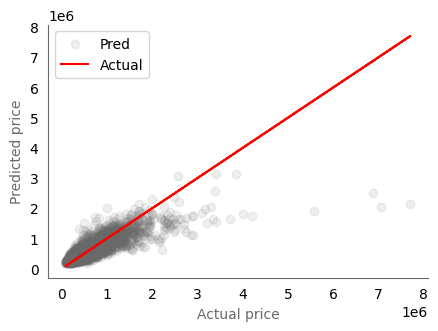

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(y_test, y_pred, color='dimgray', alpha=0.1, label='Pred')
axes.plot(y_test, y_test, color='red', label='Actual')
axes.set_xlabel('Actual price', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted price', fontsize=10, color='dimgray')
axes.legend();

## Conclusion
* LASSO regression gives:
    * R-squared: 0.55
    * MAE: 148,117
    * RMSE: 255,651
<br></br>
* k-NN gives a substantial improvement in performance with respect to linear regression for both R-squared and MAE

* It performs worse for RMSE. This is likely due to an outlier affecting this metric more.

# Random forest

## Background

### Decision trees
* A non-parametric algorithm, which can be used for both classification and regression.

* Prone to high variance and low bias

* Advantages:
    1. They can capture non-linear relationships among predictor variables
    2. They provide a set of rules, which can be communicated to lay users
    3. The trees can be visualised and used to identify important predictors

**Recursive partitioning algorithm**

* Decicision rules are learnt by repeatedly partitioning training data using predictor values that maximise within partition homogeneity (i.e. class purity) for classification tasks, and minimising variance for regression problems.


Given a training set containing P predictor variables X<sub>j</sub> for j=1,...,P and a response variable Y:

1. For each predictor variable X<sub>j</sub>:
   
   **a.** For each value x<sub>j</sub> of X<sub>j</sub>:
   
   i. Split the training set into two subpartitions with X<sub>j</sub> < x<sub>j</sub> as one partition, and the remaining records as another partition

   ii. Measure homogeneity of classes within each subpartition

   **b.** Select the x<sub>j</sub> that produces the maximum within partition homogeneity of class

2. Select the variable X<sub>j</sub> and the corresponding split value (x<sub>j</sub>) that produces maximimum within partition homogeneity of class

3. Repeat steps one and two on the resulting subpartitions

4. Terminate when no further partition can sufficiently improve the homogeneity of the partitions

**Measuring homogeneity**

* For classification problems, gini impurity or entropy are typically used.

* For regression problems, variance is minimised.

**1. Gini impurity**
   
* Measures how often a *randomly chosen* element of a set would be incorrectly labeled if it were *labeled randomly* and independently according to the distribution of labels in the set
      
* For a partition with C classes:

  $ G = \sum_{i=1}^Cp_i(1-p_i) $

  *Where, C is the total number of classes and p<sub>i</sub> is the probability of picking a point with class i.*

* A weighted average is calculated for the partitions produced by a split
  
  $ G_{avg} = \frac{\sum_{n=1}^S G_n |e_n|}{\sum_{n=1}^S |e_n|} $

  *Where, S is the number of partitions (usually 2), G<sub>n</sub> is the Gini impurity of partition n, and |e<sub>n</sub>| is the number of elements in partition n.*

* When choosing a split, we are essentially maximising the Gini gain, which is calculated by subtracting the weighted impurity (above) from the original impurity

[Source](https://victorzhou.com/blog/gini-impurity/)

**2. Entropy**

* Entropy can be thought of a quantifying information content or variance

* For a partition with C classes:

    $ E = - \sum_{i=1}^C p_i\log_2p_i $

    *Where, C is the total number of classes and p<sub>i</sub> is the probability of picking a point with class i.*

* A weighted average is calculated for the partitions produced by a split:
  
    $ E_{avg} = \frac{\sum_{n=1}^S E_n |e_n|}{\sum_{n=1}^S |e_n|} $

    *Where, S is the number of partitions (usually 2), E<sub>n</sub> is the entropy of partition n, and |e<sub>n</sub>| is the number of elements in partition n.*

* When choosing a split, we are essentially maximising the information gain, which is calculated by subtracting the weighted entropy (above) from the original entropy

[Source](https://victorzhou.com/blog/information-gain/)

**3. Variance**

The variance reduction of a split is defined as the total reduction of the variance of the target variable Y due to the split

[Source](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Gini%20impurity%20measures%20how%20often,of%20labels%20in%20the%20set.)

**Making predictions**
* For classification tasks, the majority class in the terminal node (leaf) is given -- a corresponding probability can also be given
  
* For regression tasks, the mean value of the response variable in a terminal node (leaf) is given

**Implementation**

Larger (deeper) trees are prone to overfitting. This can be mitigated by choosing appropriate hyperparameters:

1. Max depth of a tree -- the number of nodes in a tree
    
2. Minimum number of samples in a split -- minimum partition size

### Random forest
* Non-parametric

* Ensemble learning -- 

**Implementation**
* No transformation or scaling of predictive features is required -- the output is a collection of partition (decision) rules based on thresholds and any monotonic transformation shouldn't change these as they wont affect ranks in the features

**References:**
1. Practical Statistics for Data Scientists, Andrew Bruce & Peter Gedeck
2. https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote17.html
3. https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote18.html
4. https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning#tree
5. https://ocw.mit.edu/courses/6-034-artificial-intelligence-fall-2010/resources/lecture-11-learning-identification-trees-disorder/
6. https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

## Model training

In [27]:
X_train, y_train = train_df.loc[:, (train_df.columns != 'price') & (train_df.columns != 'price')], train_df.loc[:, train_df.columns == 'price']
y_train = y_train.values.ravel() # flatten

In [42]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([('rf', RandomForestRegressor(random_state=0))])
param_grid = {'rf__n_estimators': [50],
              'rf__min_samples_leaf': [2, 4, 8], # minimum size of terminal nodes
              'rf__max_leaf_nodes': [100, 1000, 2000], # maximum number of terminal nodes
}

search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_})")
print(search.best_params_)

Best parameter (CV score=0.6578473335774098)
{'rf__max_leaf_nodes': 2000, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 50}


In [46]:
oob_scores = []
n_estimator = list(range(50, 500, 50))
for n in n_estimator:
    rf = RandomForestRegressor(n_estimators=n, min_samples_leaf=2, max_leaf_nodes=1000, random_state=0, oob_score=True)
    rf.fit(X_train, y_train)
    oob_scores.append(rf.oob_score_)

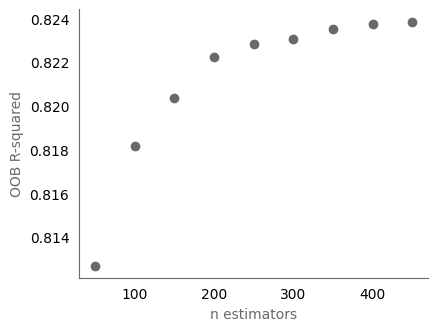

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(n_estimator, oob_scores, color='dimgray', label='Pred')
axes.set_ylabel('OOB R-squared', fontsize=10, color='dimgray')
axes.set_xlabel('n estimators', fontsize=10, color='dimgray');

## Model evaluation

In [50]:
X_test, y_test = test_df.loc[:, test_df.columns != 'price'], test_df.loc[:, test_df.columns == 'price']
y_test = y_test.values.ravel() # flatten

In [51]:
pipe = Pipeline([('rf', RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_leaf_nodes=1000, random_state=0, oob_score=True))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f"R^2: {r2_score(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")

R^2: 0.804205105588548
MAE: 86415.51199569198
RMSE: 28288215916.262745


**Test set performance**

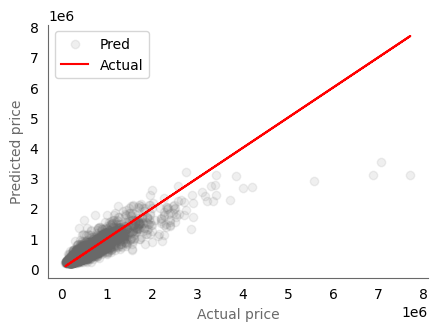

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(y_test, y_pred, color='dimgray', alpha=0.1, label='Pred')
axes.plot(y_test, y_test, color='red', label='Actual')
axes.set_xlabel('Actual price', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted price', fontsize=10, color='dimgray')
axes.legend();

**Feature importance**

In [78]:
feature_importance = [(x, y) for x, y in zip(X_train.columns, rf.feature_importances_)]
feature_importance.sort(key = lambda i:i[1], reverse=True)
feature_importance = pd.DataFrame(feature_importance, columns=['Variable', 'Importance'])
feature_importance.head()

,Variable,Importance
0,sqft_living,0.318292
1,grade,0.296758
2,zipcode,0.083497
3,yr_built,0.078419
4,sqft_living15,0.041946


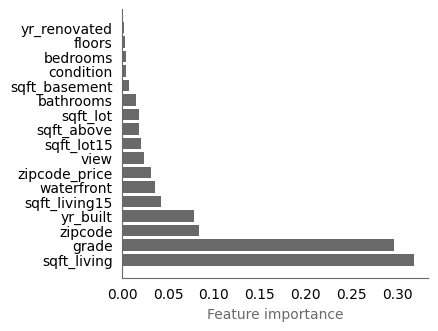

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.barh(feature_importance['Variable'], feature_importance['Importance'], color='dimgray')
axes.set_xlabel('Feature importance', fontsize=10, color='dimgray');

## Conclusion

# Gradient boosting

## Background

**References**
1. Practical Statistics for Data Scientists, Andrew Bruce & Peter Gedeck
2. https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning#tree
3. https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote19.html
4. https://ocw.mit.edu/courses/6-034-artificial-intelligence-fall-2010/resources/lecture-17-learning-boosting/
5. https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees
6. https://xgboost.ai/

## Model training

## Model evaluation

## Conclusion

# Polynomial regression

## Background

**References**
1. Practical Statistics for Data Scientists, Andrew Bruce & Peter Gedeck
2. https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features

## Model training

## Model evaluation

## Conclusion